# Multi-Asset Efficient Frontier.ipynb

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import risk_kit as rk
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
ind= rk.get_ind_returns()
er= rk.annualized_rets(ind['1996':'2000'], 12)
cov= ind['1996':'2000'].cov()

In [3]:
#Let's see the 2-asset efficient frontier function we make in the last section 
def plot_ef2(n_points, er, cov, style= '.-'):
    """
    Plots the 2-asset efficient frontier
    """
    if er.shape[0] !=2:
        raise ValueError('plot_ef2 can only plot 2-asset frontiers')
    weights= [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]
    rets = [rk.portfolio_return(w, er) for w in weights]
    vols = [rk.portfolio_vol(w, cov) for w in weights]
    efficient_frontier = pd.DataFrame({'Returns': rets, 'Volatility':vols})
    return efficient_frontier.plot.line(x='Volatility', y='Returns', style=style)

In [4]:
# Modified some parts to align with multi-assets efficient frontier
def plot_ef(n_points, er, cov, style= '.-'):
    """
    Plots the N-asset efficient frontier
    """
    weights= optimal_weights(n_points, er, cov)  #This line is not yet implemented.
    rets = [rk.portfolio_return(w, er) for w in weights]
    vols = [rk.portfolio_vol(w, cov) for w in weights]
    efficient_frontier = pd.DataFrame({'Returns': rets, 'Volatility':vols})
    return efficient_frontier.plot.line(x='Volatility', y='Returns', style=style)


The Question is: How can we minimize the volatility of the return?

<AxesSubplot:xlabel='Volatility'>

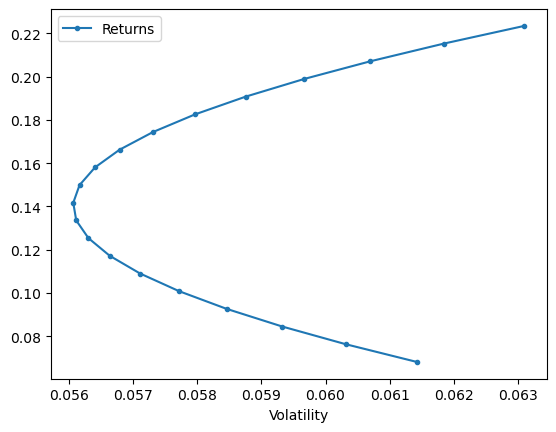

In [5]:
l = ['Games', 'Fin']
rk.plot_ef2(20, er[l], cov.loc[l, l])

How can we figure out the weights of the portfolio that gives me n% returns but with the lowest volatility?   
That's going to be our goal here.

In [6]:
#We've add these code to our module kit file
def minimize_vol(target_return, er, cov):
    """
    target_ret -> W
    """
    n = er.shape[0]                 #Number of assets
    init_guess = np.repeat(1/n, n)  #Initial guess
    bounds = ((0, 1), ) *n          #A sequence of bounds for every weights
    return_is_target = {
        'type': 'eq',  #equal
        'args': (er,),
        'fun': lambda weights, er: target_return - rk.portfolio_return(weights, er)
    }
    weights_sum_to_1= {
        'type':'eq', #equal
        'fun': lambda weights: np.sum(weights) - 1
    }
    #Run the optimizer, which is to find a solution that satisfied the bound, constraints and run the objective function(minimize the vol)
    results = minimize(rk.portfolio_vol, init_guess, 
                      args=(cov,), method="SLSQP", #This method = Quadratic Optimizer
                      options={'disp': False},
                      constraints = (return_is_target, weights_sum_to_1),
                      bounds = bounds 
                      )
    return results.x #pass back a variable collects in that structure

In [7]:
#The explanation of the bounds code above
print( (0,1) )   #It's just a tuple 
print( ((0,1)) ) #Sample tuple again
print( ((0,1))*5 ) # A big tuple of 0, 1
print( ((0, 1 ),) ) # It's a tuple of tuple
print( ((0,1),)*5 ) # 5 Copies of that

(0, 1)
(0, 1)
(0, 1, 0, 1, 0, 1, 0, 1, 0, 1)
((0, 1),)
((0, 1), (0, 1), (0, 1), (0, 1), (0, 1))


In [8]:
#Find a portfolio that has a 15% target return given these expected returns and cov matrix
w15 = minimize_vol(0.15, er[l], cov.loc[l,l]) 
w15

array([0.47287631, 0.52712369])

If we put 47% in the first asset and 52% in the other asset, we'll end up the minimum possible volatility for a 15% target return .

In [9]:
vol15 = rk.portfolio_vol(w15, cov.loc[l,l])
vol15

0.056163669406706564

<AxesSubplot:xlabel='Volatility'>

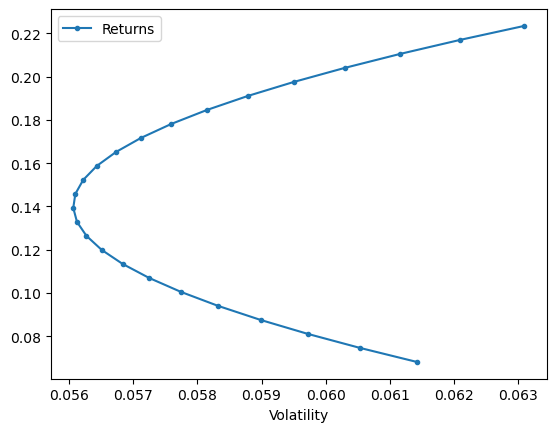

In [10]:
#Same result as our 2-asset functions, means that our optimizer is working.
rk.plot_ef2(25, er[l], cov.loc[l,l])

In [11]:
#We've add these code to our module kit file
#Generate a sequence of weight
def optimal_weights(n_points, er, cov):
    """
    -> list of weights to run the optimizer on to minimize the vol
    """
    target_rets= np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rets]
    return weights

def plot_ef(n_points, er, cov, style= '.-'):
    """
    Plots the N-asset efficient frontier
    """
    weights= optimal_weights(n_points, er, cov)
    rets = [rk.portfolio_return(w, er) for w in weights]
    vols = [rk.portfolio_vol(w, cov) for w in weights]
    efficient_frontier = pd.DataFrame({'Returns': rets, 'Volatility':vols})
    return efficient_frontier.plot.line(x='Volatility', y='Returns', style=style)

<AxesSubplot:xlabel='Volatility'>

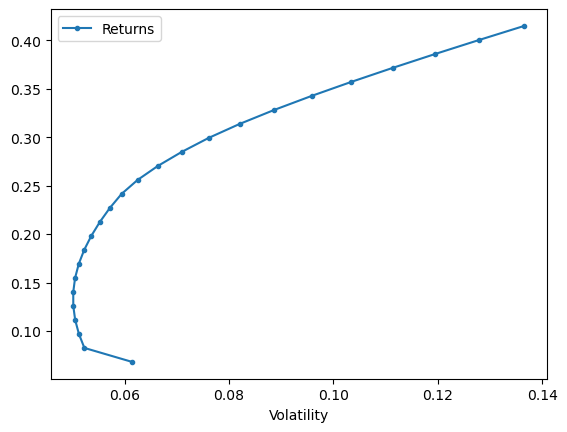

In [12]:
#Efficient Frontier for these 4 assets
l= ['Smoke', 'Fin', 'Games', 'Coal']
plot_ef(25, er[l], cov.loc[l,l])